# Relative power purchasing parity - EUR/USD FX rate prediction

**Linh Bao Pham**

*Project: Business Analytic Capstone*

## A. Data retrieving
### 1. Setting up librabries and variables

In [1]:
# Import libraries
import requests
import pandas as pd

**For the country code and index codes used below, it can be found on the country list and datacode list of IFS**

In [2]:
#Define list of country and index for data retrieve
country=[['Euro', 'U2','DE'], ['JapanYen', 'JP','JP'], ['GBPound', 'GB','GB'],['Canada$','CA','CA']]
country = pd.DataFrame(country, columns = ['currency', 'currency_code','country_code'])
index=[['cpi','PCPI_IX'],['ppi','PPPI_IX'],['pmp','PMP_IX'],['pxp','PXP_IX']]
index = pd.DataFrame(index, columns = ['price_index', 'code'])
print(country)
print(' ')
print(index)

#Define other attribute for url
startperiod='1990'
endperiod='2020'
freq='M' #data frequency, can be 'M'-monthly, 'Q'-quarterly and 'A'-annually

   currency currency_code country_code
0      Euro            U2           DE
1  JapanYen            JP           JP
2   GBPound            GB           GB
3   Canada$            CA           CA
 
  price_index     code
0         cpi  PCPI_IX
1         ppi  PPPI_IX
2         pmp   PMP_IX
3         pxp   PXP_IX


### 2. Data call for Euro currency (using price indices from Germany)

The script below is used to 
* call data from IFS via API link
* append/merge/join data set between fx and price indices
* format the data (date, number, etc.)


In [3]:
eu_data=pd.DataFrame() #create blank data frame to append data
#for i in range(len(country)):
    # define variable for each country to use
label=country.loc[0,'currency']
currency_code=country.loc[0,'currency_code']
country_code=country.loc[0,'country_code']

#Extract exchange rate data - using currency code:
url='http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/{}.{}.ENDE_XDC_USD_RATE.?startPeriod={}&endPeriod={}'.format(freq,
                                                                                                                                     currency_code,
                                                                                                                                     startperiod,
                                                                                                                                     endperiod)
#print(url)
request = requests.get(url).json()
#print(request) #print to check
fx = pd.DataFrame(request['CompactData']['DataSet']['Series']['Obs'])
fx.columns=['fx','time']
fx['currency']=label
#print(fx.head())#print to check
    
# Extract Price indices data from IFS database
price_index=fx

for j in range(len(index)):
    #print(j)
    code = index.loc[j,'code']
    index_n=index.loc[j,'price_index']
    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/{}.{}.{}.?startPeriod={}&endPeriod={}'.format(freq,
                                                                                                                            country_code,
                                                                                                                            code,
                                                                                                                            startperiod,
                                                                                                                            endperiod)
    #print(url)
    #print(index_n)
    #print(code)
    request = requests.get(url).json()
    data=pd.DataFrame(request['CompactData']['DataSet']['Series']['Obs'])
    if data.shape[1]>2:
        data=data.drop(data.columns[0], axis = 1)
    
    data.columns=[index_n,'time']
    price_index = pd.merge(left=price_index, right=data, left_on='time', right_on='time')
    #print(price_index.head())
        
eu_data=eu_data.append(price_index,ignore_index=True)
eu_data.head()

,fx,time,currency,cpi,ppi,pmp,pxp
0,0.878425860857344,1999-01,Euro,83.9069967081683,79.5553550732195,81.2593187797096,89.3470703125
1,0.907605736068252,1999-02,Euro,84.0069980573163,79.4740101293819,81.3430049988442,89.436328125
2,0.930925339787749,1999-03,Euro,84.0069980573163,79.4740101293819,82.0124947519212,89.5255859375
3,0.943663300934227,1999-04,Euro,84.4070356190253,79.9620797924078,82.5982982858635,89.61484375
4,0.956388676358072,1999-05,Euro,84.4070356190253,79.9620797924078,82.8493569432673,89.7041015625


In [4]:
# Formatting the data
## format column from char to number
eu_data['fx']=eu_data['fx'].astype(float) 
for i in index['price_index']:
    eu_data[i]=eu_data[i].astype(float)

## format time to date format
eu_data['time']=pd.to_datetime(eu_data['time'])

# Rearrange colum
eu_data=eu_data[['time','currency','fx','cpi','ppi','pmp','pxp']]

# Review data after formatting
eu_data.head()

,time,currency,fx,cpi,ppi,pmp,pxp
0,1999-01-01,Euro,0.878426,83.906997,79.555355,81.259319,89.347070
1,1999-02-01,Euro,0.907606,84.006998,79.474010,81.343005,89.436328
2,1999-03-01,Euro,0.930925,84.006998,79.474010,82.012495,89.525586
3,1999-04-01,Euro,0.943663,84.407036,79.962080,82.598298,89.614844
4,1999-05-01,Euro,0.956389,84.407036,79.962080,82.849357,89.704102


### 3. Data call for US price index

To create the purchasing power parity value, we need to have US price index to be the denominator. Using the same process to call the data in section 2, we will replicate to call the data for US price index

In [5]:
us_price_index=pd.DataFrame()
country_code='US'

for j in range(len(index)):
    #print(j)
    code = index.loc[j,'code']
    index_n=index.loc[j,'price_index']
    url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/{}.{}.{}.?startPeriod={}&endPeriod={}'.format(freq,
                                                                                                                        country_code,
                                                                                                                        code,
                                                                                                                        startperiod,
                                                                                                                        endperiod)
    #print(url)
    #print(index_n)
    #print(code)
    request = requests.get(url).json()
    data=pd.DataFrame(request['CompactData']['DataSet']['Series']['Obs'])
    
    if data.shape[1]>2:
        data=data.drop(data.columns[0], axis = 1)
    
    data.columns=[index_n,'time']
    
    if len(us_price_index)==0:
        us_price_index=data
    else:
        us_price_index = pd.merge(left=us_price_index, right=data, left_on='time', right_on='time')

us_price_index.head()

,cpi,time,ppi,pmp,pxp
0,58.4254925924822,1990-01,63.6288666834954,72.9940122316067,77.3846860056247
1,58.7006518982553,1990-02,63.3519786648553,73.1143650959622,76.8387622948268
2,59.0216710883238,1990-03,63.2412234573993,72.8134829350735,77.0434836863756
3,59.1133908569149,1990-04,63.1304682499432,72.2718950454737,77.2482050779252
4,59.2509705098014,1990-05,63.4073562685833,71.9108364524073,77.4529264694741


In [6]:
# Formatting the data
## format column from char to number
for i in index['price_index']:
    us_price_index[i]=us_price_index[i].astype(float)

## format time to date format
us_price_index['time']=pd.to_datetime(us_price_index['time'])

# Rename and rearrange colum
us_price_index.columns=['us_cpi','time','us_ppi','us_pmp','us_pxp']
us_price_index=us_price_index[['time','us_cpi','us_ppi','us_pmp','us_pxp']]

# Review data after formatting
us_price_index.head()

,time,us_cpi,us_ppi,us_pmp,us_pxp
0,1990-01-01,58.425493,63.628867,72.994012,77.384686
1,1990-02-01,58.700652,63.351979,73.114365,76.838762
2,1990-03-01,59.021671,63.241223,72.813483,77.043484
3,1990-04-01,59.113391,63.130468,72.271895,77.248205
4,1990-05-01,59.250971,63.407356,71.910836,77.452926


## B. Data processing

To have the data ready for model, the following steps are conducted:
* adding US price index
* creating input variable: 1m future exchange rate, purchasing power parity = (country price index)/(US price index)
* format the dataset (number/date format) (if needed)

### **1. Adding US price indices to the data set**

In [7]:
df = pd.merge(left=eu_data, right=us_price_index, left_on='time', right_on='time')
df.tail()

,time,currency,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp
225,2017-10-01,Euro,0.859254,109.897484,104.736341,101.308442,105.9,113.119366,112.091691,97.877095,100.710660
226,2017-11-01,Euro,0.843953,109.468615,104.944151,102.108509,106.1,113.122118,112.091691,98.823529,101.197970
227,2017-12-01,Euro,0.833820,110.004701,105.048056,102.408534,106.2,113.055621,111.796971,98.981268,101.279188
228,2018-01-01,Euro,0.802761,109.361398,105.463677,102.908576,106.5,113.671519,112.484650,99.769964,102.010152
229,2018-02-01,Euro,0.818733,109.683049,105.359771,102.308526,106.5,114.186985,112.877609,100.006572,102.172589


### **2. Adding input variables required for modelling**

Main tasks in this sections are:
* Adding future exchange rate (exchange rate 1m/3m/12m from now)
* Adding year


#### **2.1. Creating future one month exchange rate column**

In [8]:
df['fx_1m'] = 0
for i in range(len(df)-1):
    df.loc[i,'fx_1m']=df.loc[i+1,'fx'].astype(float)
    
df['fx_1m']=df['fx_1m'].astype(float)
print(df.dtypes)
df.head()

time        datetime64[ns]
currency            object
fx                 float64
cpi                float64
ppi                float64
pmp                float64
pxp                float64
us_cpi             float64
us_ppi             float64
us_pmp             float64
us_pxp             float64
fx_1m              float64
dtype: object


,time,currency,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m
0,1999-01-01,Euro,0.878426,83.906997,79.555355,81.259319,89.347070,75.347790,68.059075,72.007887,80.000000,0.907606
1,1999-02-01,Euro,0.907606,84.006998,79.474010,81.343005,89.436328,75.439510,67.726809,71.929017,79.837563,0.930925
2,1999-03-01,Euro,0.930925,84.006998,79.474010,82.012495,89.525586,75.668809,67.892942,72.165626,79.512690,0.943663
3,1999-04-01,Euro,0.943663,84.407036,79.962080,82.598298,89.614844,76.219128,68.446718,72.875452,79.675127,0.956389
4,1999-05-01,Euro,0.956389,84.407036,79.962080,82.849357,89.704102,76.219128,69.055872,73.427539,79.756345,0.968242


In [9]:
tem = pd.DataFrame({'time': pd.to_datetime(df['time'])})
L = ['year']
date_gen = (getattr(tem['time'].dt, i).rename(i) for i in L)
df = df.join(pd.concat(date_gen, axis=1))
df.head()

,time,currency,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,year
0,1999-01-01,Euro,0.878426,83.906997,79.555355,81.259319,89.347070,75.347790,68.059075,72.007887,80.000000,0.907606,1999
1,1999-02-01,Euro,0.907606,84.006998,79.474010,81.343005,89.436328,75.439510,67.726809,71.929017,79.837563,0.930925,1999
2,1999-03-01,Euro,0.930925,84.006998,79.474010,82.012495,89.525586,75.668809,67.892942,72.165626,79.512690,0.943663,1999
3,1999-04-01,Euro,0.943663,84.407036,79.962080,82.598298,89.614844,76.219128,68.446718,72.875452,79.675127,0.956389,1999
4,1999-05-01,Euro,0.956389,84.407036,79.962080,82.849357,89.704102,76.219128,69.055872,73.427539,79.756345,0.968242,1999


## C. Explanatory Data Analysis

In this section, we want to explore the relationship between variables in this data set and form hepothesis on which indices will bring best help predict the exchange rate

In [10]:
import matplotlib.pyplot as plt

# Review covariance between attribute
corr_matrix=df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,year
fx,1,-0.491902,-0.637375,-0.484315,-0.416333,-0.530053,-0.615509,-0.708934,-0.661259,0.910476,-0.465243
cpi,-0.491902,1,0.946637,0.804884,0.974124,0.996712,0.966728,0.827103,0.894192,-0.489135,0.994212
ppi,-0.637375,0.946637,1,0.909701,0.946377,0.959407,0.977603,0.939479,0.965594,-0.608218,0.923373
pmp,-0.484315,0.804884,0.909701,1,0.889471,0.820033,0.861515,0.93553,0.92566,-0.463094,0.766667
pxp,-0.416333,0.974124,0.946377,0.889471,1,0.971008,0.947803,0.855072,0.915414,-0.420923,0.962948
us_cpi,-0.530053,0.996712,0.959407,0.820033,0.971008,1,0.979916,0.848363,0.904501,-0.525956,0.991444
us_ppi,-0.615509,0.966728,0.977603,0.861515,0.947803,0.979916,1,0.910628,0.934564,-0.592055,0.952369
us_pmp,-0.708934,0.827103,0.939479,0.93553,0.855072,0.848363,0.910628,1,0.97971,-0.652068,0.785307
us_pxp,-0.661259,0.894192,0.965594,0.92566,0.915414,0.904501,0.934564,0.97971,1,-0.617875,0.859743
fx_1m,0.910476,-0.489135,-0.608218,-0.463094,-0.420923,-0.525956,-0.592055,-0.652068,-0.617875,1,-0.472856


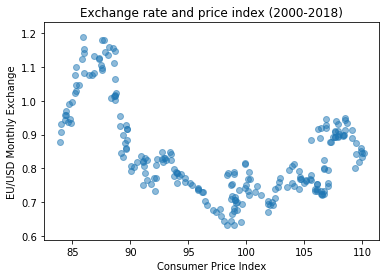

In [11]:
# Visualize fx rate and cpi
plt.scatter(df['cpi'], df['fx'], alpha=0.5)
plt.title('Exchange rate and price index (2000-2018)')
plt.xlabel('Consumer Price Index')
plt.ylabel('EU/USD Monthly Exchange')
plt.show()

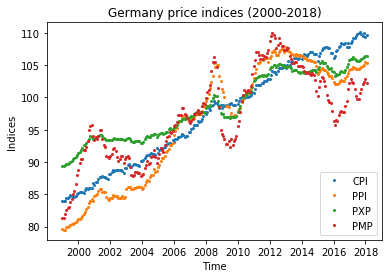

In [12]:
plt.plot_date(df['time'],df['cpi'], label="CPI",markersize=2)
plt.plot_date(df['time'],df['ppi'], label="PPI",markersize=2)
plt.plot_date(df['time'],df['pxp'], label="PXP",markersize=2)
plt.plot_date(df['time'],df['pmp'], label="PMP",markersize=2)
plt.legend(loc='lower right')
plt.title('Germany price indices (2000-2018)')
plt.xlabel('Time')
plt.ylabel('Indices')
plt.show()

## D. Modeling

In [13]:
df.head()

,time,currency,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,year
0,1999-01-01,Euro,0.878426,83.906997,79.555355,81.259319,89.347070,75.347790,68.059075,72.007887,80.000000,0.907606,1999
1,1999-02-01,Euro,0.907606,84.006998,79.474010,81.343005,89.436328,75.439510,67.726809,71.929017,79.837563,0.930925,1999
2,1999-03-01,Euro,0.930925,84.006998,79.474010,82.012495,89.525586,75.668809,67.892942,72.165626,79.512690,0.943663,1999
3,1999-04-01,Euro,0.943663,84.407036,79.962080,82.598298,89.614844,76.219128,68.446718,72.875452,79.675127,0.956389,1999
4,1999-05-01,Euro,0.956389,84.407036,79.962080,82.849357,89.704102,76.219128,69.055872,73.427539,79.756345,0.968242,1999


In [14]:
#Create list of different ppp term

import pandas as pd
r_ppp=pd.DataFrame()
r_ppp={'type':['us pmp/pxp','n.cpi/us.cpi','n.pxp/us.pxp'],
       'foreign':['us_pmp','cpi','us_pxp'],
       'us':['us_pxp','us_cpi','pxp'],
       'color':['blue','green','purple']}
r_ppp=pd.DataFrame(r_ppp,columns=['type','foreign','us','color'])
r_ppp

,type,foreign,us,color
0,us pmp/pxp,us_pmp,us_pxp,blue
1,n.cpi/us.cpi,cpi,us_cpi,green
2,n.pxp/us.pxp,us_pxp,pxp,purple


In [15]:
p_df=df #copy the dataframe to process

for j in range(len(r_ppp)):
    foreign=r_ppp.loc[j,'foreign']
    us=r_ppp.loc[j,'us']
    tppp=r_ppp.loc[j,'type']
    
    #print(tppp,'|',us,'|',foreign)
    
    for i in range(len(p_df)-1):
        if i>0:
            rev=p_df.loc[i,'fx']
            us_in=(p_df.loc[i,us]-p_df.loc[i-1,us])/p_df.loc[i-1,us]
            eu_in=(p_df.loc[i,foreign]-p_df.loc[i-1,foreign])/p_df.loc[i-1,foreign]
            if p_df.loc[i,tppp] > 0:
                p_df.loc[i+1,tppp]=((p_df.loc[i,tppp])*(1+ us_in - eu_in))
            else:
                p_df.loc[i+1,tppp]=(rev*(1+ us_in - eu_in))
        else:
            p_df.loc[i,tppp]=0
    
    p_df[tppp]=p_df[tppp].astype(float)

p_df=p_df.drop([0,1,len(df)-1],)
p_df=p_df.reset_index(drop = True) 
p_df.head()

,time,currency,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,year,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp
0,1999-03-01,Euro,0.930925,84.006998,79.474010,82.012495,89.525586,75.668809,67.892942,72.165626,79.512690,0.943663,1999,0.906757,0.907629,0.910355
1,1999-04-01,Euro,0.943663,84.407036,79.962080,82.598298,89.614844,76.219128,68.446718,72.875452,79.675127,0.956389,1999,0.900084,0.910388,0.914968
2,1999-05-01,Euro,0.956389,84.407036,79.962080,82.849357,89.704102,76.219128,69.055872,73.427539,79.756345,0.968242,1999,0.893070,0.912673,0.914011
3,1999-06-01,Euro,0.968242,84.507048,80.043425,83.100416,89.882617,76.219128,69.332760,73.269800,79.756345,0.935104,1999,0.887215,0.912673,0.913990
4,1999-07-01,Euro,0.935104,84.907075,80.287460,83.853592,90.061133,76.448427,69.609648,73.979625,79.675127,0.945805,1999,0.889121,0.911592,0.915809


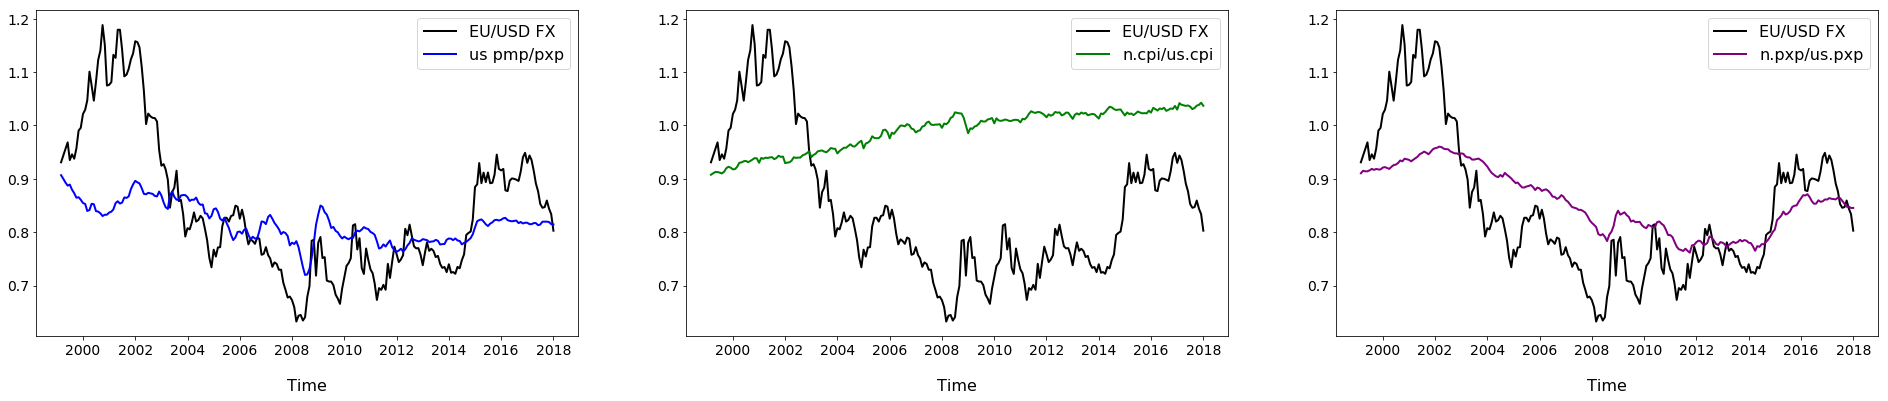

In [16]:
# Visualize the FX and the ppp-equilibrium fx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(22*1.5,4*1.5)) #setting size for the charts grid

#Plotting graph
for j in range(len(r_ppp)):
    plt.subplot(1, 3, j+1)
    plt.plot( 'time', 'fx', data=p_df, marker='', color='black', linewidth=2,label='EU/USD FX')
    plt.plot( 'time', r_ppp.loc[j,'type'], data=p_df, marker='', color=r_ppp.loc[j,'color'], linewidth=2, label=r_ppp.loc[j,'type'])
    plt.legend(fontsize=16)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

In [17]:
#Training model with different ppp term

#cut off year for training model
cutoff='20151231'

import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

mdf=p_df
mdf=mdf.drop(columns=['cpi','ppi','pxp','pmp','us_cpi','us_ppi','us_pmp','us_pxp','year'])
mdf.head()

,time,currency,fx,fx_1m,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp
0,1999-03-01,Euro,0.930925,0.943663,0.906757,0.907629,0.910355
1,1999-04-01,Euro,0.943663,0.956389,0.900084,0.910388,0.914968
2,1999-05-01,Euro,0.956389,0.968242,0.893070,0.912673,0.914011
3,1999-06-01,Euro,0.968242,0.935104,0.887215,0.912673,0.913990
4,1999-07-01,Euro,0.935104,0.945805,0.889121,0.911592,0.915809


In [96]:
# equation:
# log(fx_1m)-log(fx)= a + b*(log(fx)-log(ppp))



#Training model with different ppp term
cutoff='20151231' #cut off year for training model

import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

for j in range(len(r_ppp)):
    
    #type of ppp term
    ppp=r_ppp.loc[j,'type']
    #tem=p_df
    #creating the input and output variables
    
    for obj in ('time','year','fx_1m','fx',ppp):
        tem[obj]=p_df[obj]
        #tem=tem[['time','year','fx_1m','fx',ppp]]
    tem['y']=np.log(tem['fx_1m'])-np.log(tem['fx'])
    tem['x']=np.log(tem['fx'])-np.log(tem[ppp])
    
    train=tem.loc[:cutoff]
    test=tem.loc[cutoff:]
    
    #print(train.head())
    
    #Train the model
    regr = linear_model.LinearRegression()
    x = np.asanyarray(train['x']).reshape(-1, 1)
    y = np.asanyarray(train['y']).reshape(-1, 1)
    regr.fit (x, y)
    #print(train.head())
    
    #Record the model performance - in-sample
    ## Performance in log output
    train['y_pred']=regr.predict(x)
    r_ppp.loc[j,'in_mse_log']=mean_squared_error(y,train['y_pred'])
    r_ppp.loc[j,'in_r2_log']=r2_score(y,train['y_pred'])  
    
    ## Performance in fx output
    train['fx1m_pred']=np.exp(train['y_pred']+np.log(train['fx']))
    r_ppp.loc[j,'in_mse']=mean_squared_error(train['fx_1m'],train['fx1m_pred'])
    r_ppp.loc[j,'in_r2']=r2_score(train['fx_1m'],train['fx1m_pred'])
    
    
    #Record the model performance - in-sample
    ## Performance in log output
    test['y_pred']=regr.predict(np.asanyarray(test['x']).reshape(-1, 1))
    r_ppp.loc[j,'out_mse_log']=mean_squared_error(test['y'],test['y_pred'])
    r_ppp.loc[j,'out_r2_log']=r2_score(test['y'],test['y_pred'])
    
    ## Performance in fx output
    test['fx1m_pred']=np.exp(test['y_pred']+np.log(test['fx']))
    r_ppp.loc[j,'out_mse']=mean_squared_error(test['fx_1m'],test['fx1m_pred'])
    r_ppp.loc[j,'out_r2']=r2_score(test['fx_1m'],test['fx1m_pred'])    
    
    
    # Addding the prediction to the dataset
    name='p('+r_ppp.loc[j,'type']+')'
    mdf[name]=regr.predict(np.asanyarray(tem['x']).reshape(-1, 1))
    mdf[name]=np.exp(mdf[name]+tem['x']+np.log(mdf['fx']))
    

/Users/lbpham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lbpham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lbpham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

# Model evaluation

To evaluate the model, we will look at:
* Predicted vs. actual FX
* Statistical performance (R2 and mean square error)
* FX direction prediction level


**1. Predicted vs. actual FX**

In [93]:
mdf.head()

,time,currency,fx,fx_1m,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp,p(us pmp/pxp),p(n.cpi/us.cpi),p(n.pxp/us.pxp)
0,1999-03-01,Euro,0.930925,0.943663,0.906757,0.907629,0.910355,0.930675,0.928066,0.930007
1,1999-04-01,Euro,0.943663,0.956389,0.900084,0.910388,0.914968,0.943089,0.940614,0.942594
2,1999-05-01,Euro,0.956389,0.968242,0.893070,0.912673,0.914011,0.955478,0.953141,0.955069
3,1999-06-01,Euro,0.968242,0.935104,0.887215,0.912673,0.913990,0.967024,0.964773,0.966701
4,1999-07-01,Euro,0.935104,0.945805,0.889121,0.911592,0.915809,0.934487,0.932230,0.934205


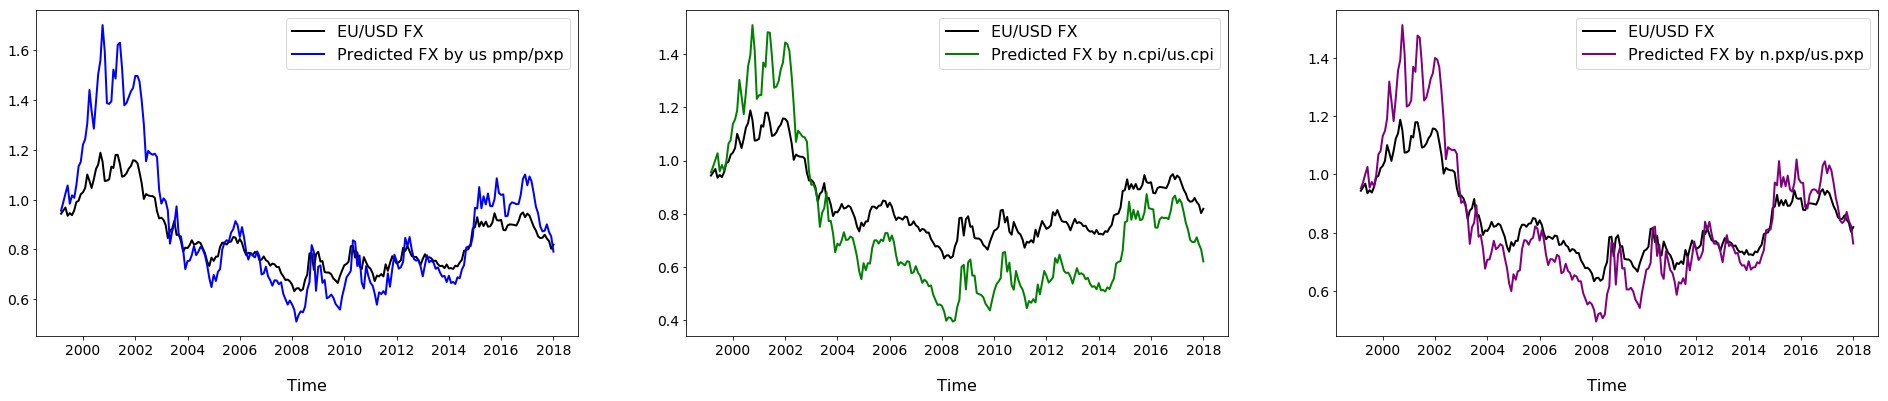

In [95]:
# Visualize the FX and the ppp-equilibrium fx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(22*1.5,4*1.5)) #setting size for the charts grid

#Plotting graph
for j in range(len(r_ppp)):
    plt.subplot(1, 3, j+1)
    name='p('+r_ppp.loc[j,'type']+')'
    label='Predicted FX by '+r_ppp.loc[j,'type']
    plt.plot( 'time', 'fx_1m', data=mdf, marker='', color='black', linewidth=2,label='EU/USD FX')
    plt.plot( 'time', name , data=mdf, marker='', color=r_ppp.loc[j,'color'], linewidth=2, label=label)
    plt.legend(fontsize=16)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

**2. Statistical performance**

In [21]:
r_ppp.head()

,type,foreign,us,color,in_mse_log,in_r2_log,in_mse,in_r2,out_mse_log,out_r2_log,out_mse,out_r2
0,us pmp/pxp,us_pmp,us_pxp,blue,0.000902,0.004673,0.000645,0.966593,0.000361,-0.025491,0.000281,0.820387
1,n.cpi/us.cpi,cpi,us_cpi,green,0.000898,0.008936,0.000644,0.966647,0.000368,-0.046946,0.000287,0.816667
2,n.pxp/us.pxp,us_pxp,pxp,purple,0.000902,0.003947,0.000646,0.966552,0.000361,-0.026030,0.000281,0.820249


In [22]:
import matplotlib.pyplot as plt

# Review covariance between attribute
r2=r_ppp[['type','in_r2_log','in_r2','out_r2_log','out_r2']]
r2.style.background_gradient(cmap='coolwarm')

,type,in_r2_log,in_r2,out_r2_log,out_r2
0,us pmp/pxp,0.00467321,0.966593,-0.0254908,0.820387
1,n.cpi/us.cpi,0.00893621,0.966647,-0.0469464,0.816667
2,n.pxp/us.pxp,0.0039474,0.966552,-0.0260301,0.820249


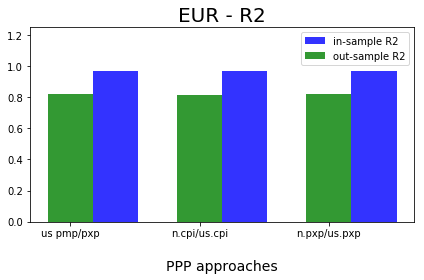

In [23]:
n_groups = len(r_ppp)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

#for j in range(len(r_ppp)):
    #plt.subplot(1, 3, j+1)
plt.bar(index + bar_width*j, r_ppp['in_r2'], bar_width,
        alpha=opacity,
        color='b',
        label='in-sample R2')

plt.bar(index + bar_width, r_ppp['out_r2'], bar_width,
        alpha=opacity,
        color='g',
        label='out-sample R2')

plt.xlabel('\nPPP approaches',fontsize = 14)
plt.title('EUR - R2',fontsize = 20)
plt.xticks(index + bar_width, r_ppp['type'],fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylim(top=1.25)
plt.tight_layout()
plt.legend()

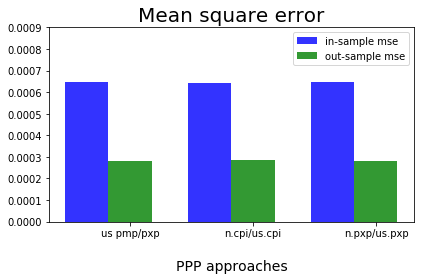

In [24]:
n_groups = len(r_ppp)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

#for j in range(len(r_ppp)):
    #plt.subplot(1, 3, j+1)
plt.bar(index, r_ppp['in_mse'], bar_width,
        alpha=opacity,
        color='b',
        label='in-sample mse')

plt.bar(index + bar_width, r_ppp['out_mse'], bar_width,
        alpha=opacity,
        color='g',
        label='out-sample mse')

plt.xlabel('\nPPP approaches',fontsize = 14)
plt.title('Mean square error',fontsize = 20)
plt.xticks(index + bar_width, r_ppp['type'],fontsize = 10)
plt.ylim(top=0.0009)
plt.tight_layout()
plt.legend()

**3. FX direction change prediction**

In [25]:
mdf.head()

,time,currency,fx,fx_1m,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp,p(us pmp/pxp),p(n.cpi/us.cpi),p(n.pxp/us.pxp)
0,1999-03-01,Euro,0.930925,0.943663,0.906757,0.907629,0.910355,0.955738,0.954820,0.951960
1,1999-04-01,Euro,0.943663,0.956389,0.900084,0.910388,0.914968,0.989352,0.978155,0.973258
2,1999-05-01,Euro,0.956389,0.968242,0.893070,0.912673,0.914011,1.024197,1.002198,1.000731
3,1999-06-01,Euro,0.968242,0.935104,0.887215,0.912673,0.913990,1.056669,1.027193,1.025714
4,1999-07-01,Euro,0.935104,0.945805,0.889121,0.911592,0.915809,0.983465,0.959222,0.954805


In [26]:
r_ppp

,type,foreign,us,color,in_mse_log,in_r2_log,in_mse,in_r2,out_mse_log,out_r2_log,out_mse,out_r2
0,us pmp/pxp,us_pmp,us_pxp,blue,0.000902,0.004673,0.000645,0.966593,0.000361,-0.025491,0.000281,0.820387
1,n.cpi/us.cpi,cpi,us_cpi,green,0.000898,0.008936,0.000644,0.966647,0.000368,-0.046946,0.000287,0.816667
2,n.pxp/us.pxp,us_pxp,pxp,purple,0.000902,0.003947,0.000646,0.966552,0.000361,-0.026030,0.000281,0.820249


In [34]:
#create new result dataframe for direction change:
direct=pd.DataFrame()
direct['time']=mdf['time']
direct['fx_direct']=mdf['fx_1m']-mdf['fx']

for j in range(len(r_ppp)):
    label='p('+r_ppp.loc[j,'type']+')'
    #label=r_ppp.loc[j,'type']
    direct[r_ppp.loc[j,'type']]=mdf[label]-mdf['fx']

direct.head()

,time,fx_direct,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp
0,1999-03-01,0.012738,0.024813,0.023894,0.021035
1,1999-04-01,0.012725,0.045689,0.034492,0.029595
2,1999-05-01,0.011853,0.067808,0.045809,0.044342
3,1999-06-01,-0.033138,0.088427,0.058952,0.057472
4,1999-07-01,0.010702,0.048361,0.024118,0.019702


In [35]:
for i in range(len(direct)):
    if direct.loc[i,'fx_direct']>0:
        direct.loc[i,'actual']=1
    else:
        direct.loc[i,'actual']=-1

direct.head()
        
for j in range(len(r_ppp)):
    label='p('+r_ppp.loc[j,'type']+')'
    for i in range(len(direct)):
        if direct.loc[i,r_ppp.loc[j,'type']]>0:
            direct.loc[i,label]=1
        else:
            direct.loc[i,label]=-1
    
direct.head()

,time,fx_direct,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp,actual,p(us pmp/pxp),p(n.cpi/us.cpi),p(n.pxp/us.pxp)
0,1999-03-01,0.012738,0.024813,0.023894,0.021035,1.0,1.0,1.0,1.0
1,1999-04-01,0.012725,0.045689,0.034492,0.029595,1.0,1.0,1.0,1.0
2,1999-05-01,0.011853,0.067808,0.045809,0.044342,1.0,1.0,1.0,1.0
3,1999-06-01,-0.033138,0.088427,0.058952,0.057472,-1.0,1.0,1.0,1.0
4,1999-07-01,0.010702,0.048361,0.024118,0.019702,1.0,1.0,1.0,1.0


In [37]:
for j in range(len(r_ppp)):
    count=0
    for i in range(len(direct)):
        if direct.loc[i,r_ppp.loc[j,'type']]*direct.loc[i,'actual']>0:
            count=count+1
    print(r_ppp.loc[j,'type'], ' : ', count, ' / ', len(direct))
    r_ppp.loc[j,'direct']=count/len(direct)

r_ppp

us pmp/pxp  :  110  /  227
n.cpi/us.cpi  :  119  /  227
n.pxp/us.pxp  :  117  /  227


,type,foreign,us,color,in_mse_log,in_r2_log,in_mse,in_r2,out_mse_log,out_r2_log,out_mse,out_r2,direct
0,us pmp/pxp,us_pmp,us_pxp,blue,0.000902,0.004673,0.000645,0.966593,0.000361,-0.025491,0.000281,0.820387,0.484581
1,n.cpi/us.cpi,cpi,us_cpi,green,0.000898,0.008936,0.000644,0.966647,0.000368,-0.046946,0.000287,0.816667,0.524229
2,n.pxp/us.pxp,us_pxp,pxp,purple,0.000902,0.003947,0.000646,0.966552,0.000361,-0.026030,0.000281,0.820249,0.515419


# Model customization


In [38]:
p_df.head()

,time,currency,fx,cpi,ppi,pmp,pxp,us_cpi,us_ppi,us_pmp,us_pxp,fx_1m,year,us pmp/pxp,n.cpi/us.cpi,n.pxp/us.pxp
0,1999-03-01,Euro,0.930925,84.006998,79.474010,82.012495,89.525586,75.668809,67.892942,72.165626,79.512690,0.943663,1999,0.906757,0.907629,0.910355
1,1999-04-01,Euro,0.943663,84.407036,79.962080,82.598298,89.614844,76.219128,68.446718,72.875452,79.675127,0.956389,1999,0.900084,0.910388,0.914968
2,1999-05-01,Euro,0.956389,84.407036,79.962080,82.849357,89.704102,76.219128,69.055872,73.427539,79.756345,0.968242,1999,0.893070,0.912673,0.914011
3,1999-06-01,Euro,0.968242,84.507048,80.043425,83.100416,89.882617,76.219128,69.332760,73.269800,79.756345,0.935104,1999,0.887215,0.912673,0.913990
4,1999-07-01,Euro,0.935104,84.907075,80.287460,83.853592,90.061133,76.448427,69.609648,73.979625,79.675127,0.945805,1999,0.889121,0.911592,0.915809


In [64]:
df1=pd.DataFrame()
for i in ('time','year','fx','fx_1m'):
    df1[i]=p_df[i]
#df1=p_df[['time','year','fx','fx_1m']]
df1['y']=np.log(p_df['fx_1m'])-np.log(p_df['fx'])
for i in range(len(r_ppp)):
    label='x'+str(i+1)
    df1[label]=np.log(p_df['fx'])-np.log(p_df[r_ppp.loc[i,'type']])
        
df1.head()

,time,year,fx,fx_1m,y,x1,x2,x3
0,1999-03-01,1999,0.930925,0.943663,0.013590,0.026305,0.025344,0.022344
1,1999-04-01,1999,0.943663,0.956389,0.013395,0.047281,0.035899,0.030880
2,1999-05-01,1999,0.956389,0.968242,0.012317,0.068499,0.046786,0.045321
3,1999-06-01,1999,0.968242,0.935104,-0.034824,0.087395,0.059104,0.057662
4,1999-07-01,1999,0.935104,0.945805,0.011379,0.050425,0.025465,0.020850


In [65]:
cutoff='20151231'

train=df1.loc[:cutoff]
test=df1.loc[cutoff:]

reg_a = linear_model.LinearRegression()
x_train = train[['x1','x2','x3']].values
y_train = train['y'].values
reg_a.fit(x_train, y_train)
coeff_df = pd.DataFrame(reg_a.coef_, ['x1','x2','x3'], columns=['Coefficient'])  
coeff_df

,Coefficient
x1,0.060026
x2,-0.042863
x3,-0.020730


In [66]:
df1['y_pred']=reg_a.predict(df1[['x1','x2','x3']].values)
df1['fx1m_pred']=np.exp(df1['y_pred']+np.log(df1['fx']))
df1.head()

,time,year,fx,fx_1m,y,x1,x2,x3,y_pred,fx1m_pred
0,1999-03-01,1999,0.930925,0.943663,0.013590,0.026305,0.025344,0.022344,-0.008927,0.922652
1,1999-04-01,1999,0.943663,0.956389,0.013395,0.047281,0.035899,0.030880,-0.008298,0.935866
2,1999-05-01,1999,0.956389,0.968242,0.012317,0.068499,0.046786,0.045321,-0.007790,0.948967
3,1999-06-01,1999,0.968242,0.935104,-0.034824,0.087395,0.059104,0.057662,-0.007440,0.961065
4,1999-07-01,1999,0.935104,0.945805,0.011379,0.050425,0.025465,0.020850,-0.007454,0.928160


(array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3]),
 <a list of 8 Text yticklabel objects>)

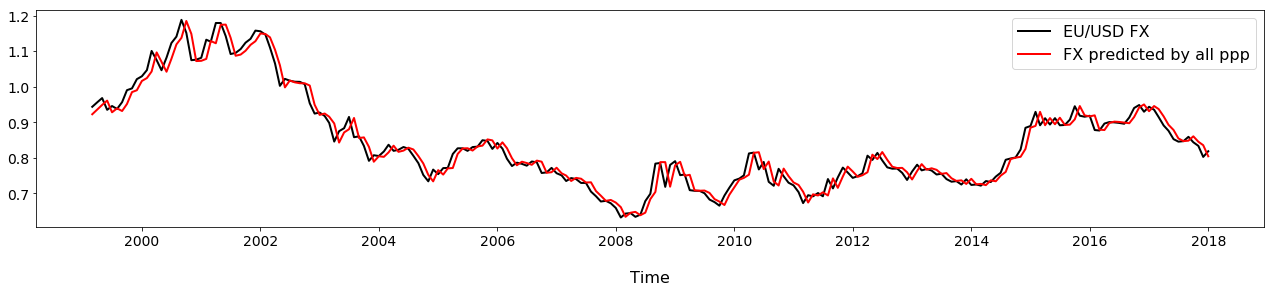

In [75]:
plt.figure(figsize=(22,4)) #setting size for the charts grid

plt.plot( 'time', 'fx_1m', data=df1, marker='', color='black', linewidth=2,label='EU/USD FX')
plt.plot( 'time', 'fx1m_pred' , data=df1, marker='', color='red', linewidth=2, label='FX predicted by all ppp')
plt.legend(fontsize=16)
plt.xlabel('\nTime',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)